# Hierarchichal Bayesian Model

Data Scientist: John Adeojo
Data: 29/01/2023

Purpose: Using bayesian hierarchichal models to estimate goal statistics with english football league data

In [1]:
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
from scipy import special, stats
import numpy as npimport warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
from numpy.random import normal


#import theano


import datetime
print(f"Last Run {datetime.datetime.now()}")

Last Run 2023-01-29 13:57:26.991198


# Import data

In [2]:
import os
import requests
import pandas as pd
import warnings
from datetime import datetime

def download_files(filepath, N):
    url = f"https://www.football-data.co.uk/mmz4281/{filepath}/{N}.csv"
    response = requests.get(url)
    directory = "/home/data-scientist/Documents/Football Modelling/Data"
    os.makedirs(directory, exist_ok=True)
    file_name = f"{filepath}_{N}_{datetime.now().strftime('%Y-%m-%d %H-%M-%S')}.csv"
    open(os.path.join(directory, file_name), "wb").write(response.content)
    df = pd.read_csv(os.path.join(directory, file_name),encoding='latin1')
    return df

def data_quality_checks(df):
    if df.isnull().sum().sum() > 0:
        raise ValueError("Dataframe contains missing values")
    if df.duplicated().sum() > 0:
        raise ValueError("Dataframe contains duplicates")

filepath_values = ["1819", "1920", "2021", "2122", "2223"]
N_values = ["E0", "E1", "E2", "E3", "EC"]
directory = "/home/data-scientist/Documents/Football Modelling/Data"



final_df_file = os.path.join(directory, "final_df.csv")
if os.path.isfile(final_df_file):
    final_df = pd.read_csv(final_df_file)
else:
    final_df = pd.DataFrame()
    for filepath in filepath_values:
        for N in N_values:
            df = download_files(filepath, N)
            try:
                data_quality_checks(df)
            except ValueError as e:
                warnings.warn(f"{filepath}_{N} has {e}")
            final_df = pd.concat([final_df, df], ignore_index=True)
    final_df.to_csv(final_df_file, index=False)


/tmp/ipykernel_4069/2790345706.py:31: DtypeWarning: Columns (53) have mixed types. Specify dtype option on import or set low_memory=False.
  final_df = pd.read_csv(final_df_file)


In [3]:
# Supress uneccessary warnings

import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [4]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    df = final_df

    columns_to_keep = ["Div","Date","HomeTeam","AwayTeam","FTHG","FTAG","FTR","HTHG","HTAG","HTR"]
    df = df[columns_to_keep].copy()
    df["Date"] = pd.to_datetime(df['Date'])
    df["Month"] = df['Date'].dt.month
    df["Game"] = df.apply(lambda x: x["HomeTeam"] + " vs " + x["AwayTeam"], axis=1)


    df.loc[:, 'Total Goals'] = df[['FTHG', 'FTAG']].sum(axis=1)
    df.loc[:, 'Total FHG'] = df[['HTHG', 'HTAG']].sum(axis=1)
    df.loc[:, 'Both_Teams_Score'] = np.where((df['FTHG'] > 0) & (df['FTAG'] > 0), 1, 0)
    df.loc[:, 'Under 2.5 Goals'] = np.where((df['Total Goals'] < 2.5) , 1, 0)
    df.loc[:, 'Over 2.5 Goals'] = np.where((df['Total Goals'] > 2.5) , 1, 0)
    df.loc[:, 'Under 0.5 Goals'] = np.where((df['Total Goals'] < 0.5) , 1, 0)
    df.loc[:, 'Over 0.5 Goals'] = np.where((df['Total Goals'] > 0.5) , 1, 0)
    df.loc[:, 'Under 1.5 Goals'] = np.where((df['Total Goals'] < 1.5) , 1, 0)
    df.loc[:, 'Over 1.5 Goals'] = np.where((df['Total Goals'] > 1.5) , 1, 0)
    df.loc[:, 'Under 3.5 Goals'] = np.where((df['Total Goals'] < 3.5) , 1, 0)
    df.loc[:, 'Over 3.5 Goals'] = np.where((df['Total Goals'] > 3.5) , 1, 0)
    df.loc[:, 'Under 4.5 Goals'] = np.where((df['Total Goals'] < 4.5) , 1, 0)
    df.loc[:, 'Over 4.5 Goals'] = np.where((df['Total Goals'] > 4.5) , 1, 0)
    df.loc[:, 'First Half Goals 0.5'] = np.where((df['Total FHG'] < 0.5) , 1, 0)
    df.loc[:, 'First Half Goals 1.5'] = np.where((df['Total FHG'] < 1.5) , 1, 0)
    df['Div'] = df['Div'].astype('category')
    df['HomeTeam'] = df['HomeTeam'].astype('category')
    df['AwayTeam'] = df['AwayTeam'].astype('category')
    df['Game'] = df['Game'].astype('category')
    
    fxn()





In [5]:
#df_prior = df.loc[df['Date'] <= (max(df['Date']) - pd.Timedelta(days=730))]
#df_observed = (df.loc[df['Date'] >= (max(df['Date']) - pd.Timedelta(days=730))])

df_observed = df

print(df_observed.shape)
#print(df_prior.shape)

(11289, 27)


# Data Anaysis 

In [6]:
df_observed["HomeTeam"].value_counts().to_csv('homecounts')

<AxesSubplot:>

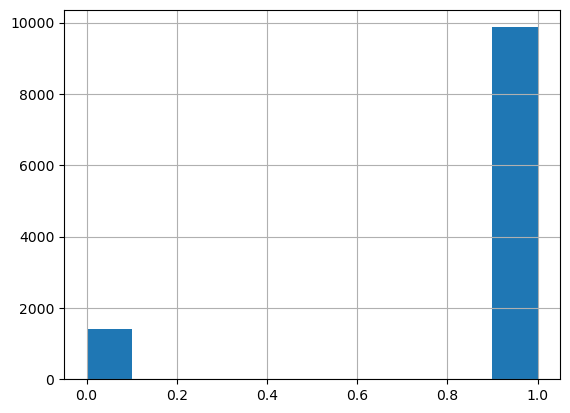

In [7]:
df_observed["Under 4.5 Goals"].hist()

In [8]:
df.tail()

Div       Date      HomeTeam      AwayTeam  FTHG  FTAG FTR  HTHG  HTAG  \
11284  EC 2023-10-01  Notts County  Boreham Wood     1     1   D   0.0   1.0   
11285  EC 2023-01-14       Bromley        Yeovil     4     1   H   2.0   0.0   
11286  EC 2023-01-14    Scunthorpe        Woking     0     2   A   0.0   1.0   
11287  EC 2023-01-17    Altrincham    Maidenhead     3     2   H   2.0   2.0   
11288  EC 2023-01-17      Solihull     Aldershot     1     2   A   0.0   2.0   

      HTR  ...  Under 0.5 Goals Over 0.5 Goals  Under 1.5 Goals  \
11284   A  ...                0              1                0   
11285   H  ...                0              1                0   
11286   A  ...                0              1                0   
11287   D  ...                0              1                0   
11288   A  ...                0              1                0   

       Over 1.5 Goals  Under 3.5 Goals  Over 3.5 Goals  Under 4.5 Goals  \
11284               1                1               0                1   
11285               1                0               1                0   
11286               1                1               0                1   
11287               1                0               1                0   
11288               1                1               0                1   

       Over 4.5 Goals  First Half Goals 0.5  First Half Goals 1.5  
11284               0                     0                     1  
11285               1                     0                     0  
11286               0                     0                     1  
11287               1                     0                     0  
11288               0                     0                     0  

[5 rows x 27 columns]

# Parameters for estimation:

In [9]:
# Hierarchies
HomeTeam_idx = df_observed.HomeTeam.cat.codes.values
HomeTeam_codes = df_observed.HomeTeam.cat.categories
Div_idx = df_observed.Div.cat.codes.values
Div_codes = df_observed.Div.cat.categories
Game_idx = df_observed.Game.cat.codes.values
Game_codes = df_observed.Game.cat.categories

n_HomeTeam = HomeTeam_codes.size
n_Div = Div_codes.size
n_Game = Game_codes.size

# Parameters
BothTeamsScore_game = np.array(df_observed["Both_Teams_Score"])
U2_5G_game = np.array(df_observed["Under 2.5 Goals"])
U0_5G_game = np.array(df_observed["Under 0.5 Goals"])
U1_5G_game = np.array(df_observed["Under 1.5 Goals"])
U3_5G_game = np.array(df_observed["Under 3.5 Goals"])
U4_5G_game = np.array(df_observed["Under 4.5 Goals"])
FH_U0_5G_game = np.array(df_observed['First Half Goals 0.5'])
FH_U1_5G_game = np.array(df_observed['First Half Goals 1.5'])

# unique_teams = np.unique(Div_idx)
# num_unique_teams = len(unique_teams)
# print(num_unique_teams)


print('n_HomeTeam',n_HomeTeam)
print('n_Div', n_Div)

print(n_HomeTeam)
#with np.printoptions(threshold=np.inf):
    #print(HomeTeam_idx)


n_HomeTeam 126
n_Div 5
126


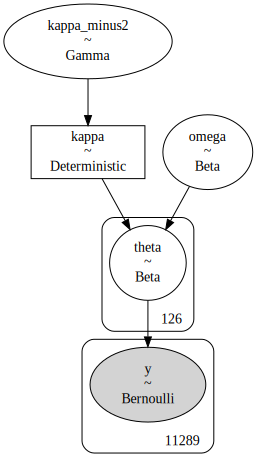

In [10]:
with pm.Model() as hierarchical_model:
    
    # priors
    omega = pm.Beta('omega', 1., 1.)
    kappa_minus2 = pm.Gamma('kappa_minus2', 0.01, 0.01)
    kappa = pm.Deterministic('kappa', kappa_minus2 + 2)
    
    
    # Parameter to estimate
    theta = pm.Beta('theta', alpha=omega*(kappa-2)+1, beta=(1-omega)*(kappa-2)+1, shape=n_HomeTeam)
    
    
    #  Bernoulli Likelihood 
    y = pm.Bernoulli('y', theta[HomeTeam_idx], observed=U4_5G_game)    

pm.model_to_graphviz(hierarchical_model)



# MCMC Sampling

In [13]:
with hierarchical_model:
    trace = pm.sample(draws=2000, tune=3000, target_accept=0.95, cores=4, idata_kwargs={"log_likelihood": True}, return_inferencedata=False)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega, kappa_minus2, theta]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 59 seconds.


In [14]:
trace

<MultiTrace: 4 chains, 2000 iterations, 7 variables>

## Sample data storage 

In [15]:
#var_names = ['omega', 'kappa_minus2', 'theta', "y"]

with hierarchical_model:
    posterior_predictive  = pm.sample_posterior_predictive(trace=trace, 
                                         return_inferencedata=False)


Sampling: [y]


In [16]:
var_names = ["kappa_minus2", "omega"]
with hierarchical_model:
    prior_predictive = pm.sample_prior_predictive(samples=2000, 
                                                  #var_names=var_names,
                                                 return_inferencedata=False,
                                                 )


Sampling: [kappa_minus2, omega, theta, y]


In [17]:
with hierarchical_model:
    idata = pm.to_inference_data(trace=trace, posterior_predictive=posterior_predictive, prior=prior_predictive, log_likelihood=True)
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

# Model Diagnostics: Prior Predictive Plots

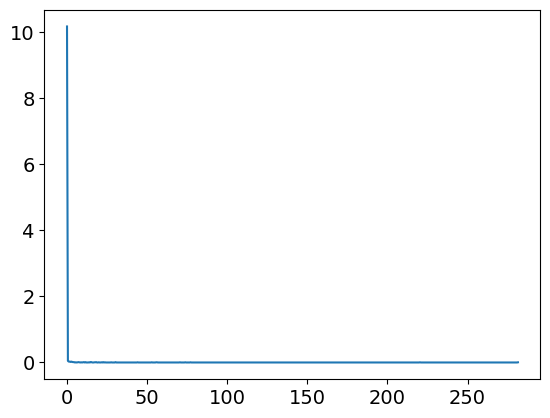

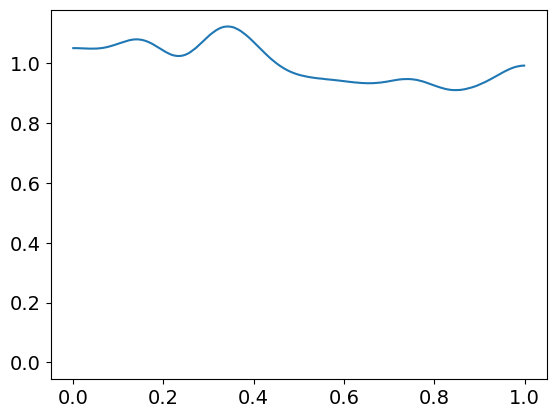

In [18]:
for variable in var_names:
    az.plot_dist(idata.prior[variable]) 
    plt.show()

# Model Diagnostics: Model Convergence

array([[<AxesSubplot:title={'center':'omega'}>,
        <AxesSubplot:title={'center':'omega'}>],
       [<AxesSubplot:title={'center':'kappa_minus2'}>,
        <AxesSubplot:title={'center':'kappa_minus2'}>],
       [<AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'theta'}>],
       [<AxesSubplot:title={'center':'kappa'}>,
        <AxesSubplot:title={'center':'kappa'}>]], dtype=object)

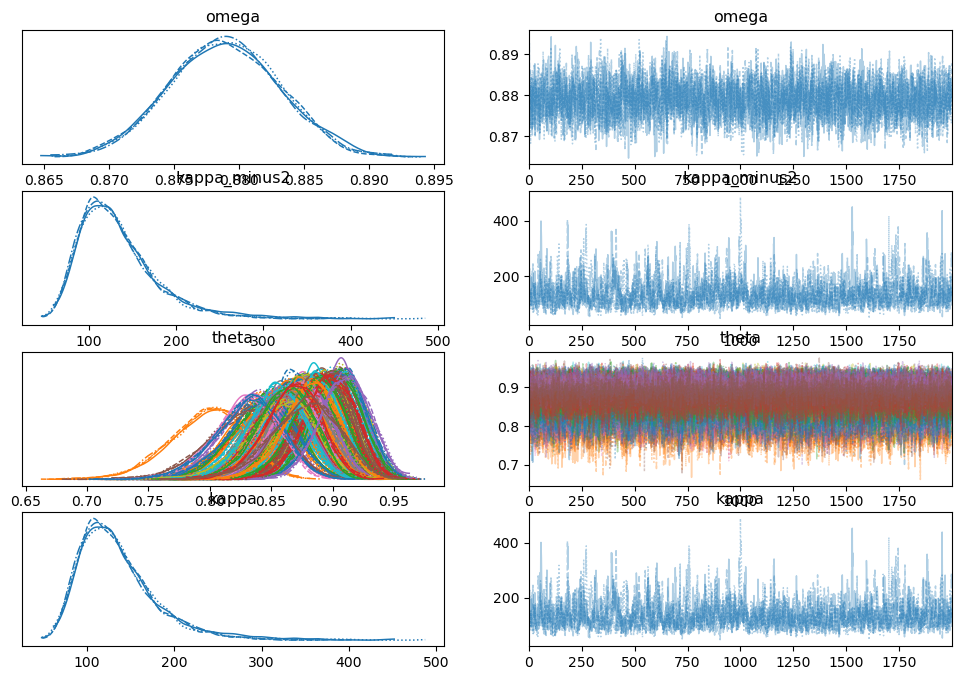

In [19]:
az.plot_trace(idata)

In [20]:
az.summary(idata)

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
omega           0.879   0.004   0.871    0.887      0.000    0.000    2803.0   
kappa_minus2  133.493  46.064  65.067  217.330      1.448    1.024    1098.0   
theta[0]        0.875   0.022   0.833    0.915      0.000    0.000   10041.0   
theta[1]        0.845   0.025   0.796    0.890      0.000    0.000    8114.0   
theta[2]        0.884   0.021   0.844    0.923      0.000    0.000    9555.0   
...               ...     ...     ...      ...        ...      ...       ...   
theta[122]      0.861   0.023   0.818    0.904      0.000    0.000    8454.0   
theta[123]      0.867   0.023   0.825    0.910      0.000    0.000    9010.0   
theta[124]      0.910   0.020   0.872    0.946      0.000    0.000    5514.0   
theta[125]      0.877   0.028   0.826    0.930      0.000    0.000    9845.0   
kappa         135.493  46.064  67.067  219.330      1.448    1.024    1098.0   

              ess_tail  r_hat  
omega           4451.0    1.0  
kappa_minus2    1680.0    1.0  
theta[0]        5335.0    1.0  
theta[1]        5247.0    1.0  
theta[2]        5675.0    1.0  
...                ...    ...  
theta[122]      5602.0    1.0  
theta[123]      5706.0    1.0  
theta[124]      4577.0    1.0  
theta[125]      5663.0    1.0  
kappa           1680.0    1.0  

[129 rows x 9 columns]

/home/data-scientist/anaconda3/lib/python3.9/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (129) in plot_mcse, generating only 40 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'omega'}, xlabel='Quantile', ylabel='MCSE for quantiles'>,
        <AxesSubplot:title={'center':'kappa_minus2'}, xlabel='Quantile', ylabel='MCSE for quantiles'>,
        <AxesSubplot:title={'center':'theta\n0'}, xlabel='Quantile', ylabel='MCSE for quantiles'>,
        <AxesSubplot:title={'center':'theta\n1'}, xlabel='Quantile', ylabel='MCSE for quantiles'>],
       [<AxesSubplot:title={'center':'theta\n2'}, xlabel='Quantile', ylabel='MCSE for quantiles'>,
        <AxesSubplot:title={'center':'theta\n3'}, xlabel='Quantile', ylabel='MCSE for quantiles'>,
        <AxesSubplot:title={'center':'theta\n4'}, xlabel='Quantile', ylabel='MCSE for quantiles'>,
        <AxesSubplot:title={'center':'theta\n5'}, xlabel='Quantile', ylabel='MCSE for quantiles'>],
       [<AxesSubplot:title={'center':'theta\n6'}, xlabel='Quantile', ylabel='MCSE for quantiles'>,
        <AxesSubplot:title={'center':'theta\n7'}, xlabel='Quantile', ylabel='MCSE for quantiles'>,
       

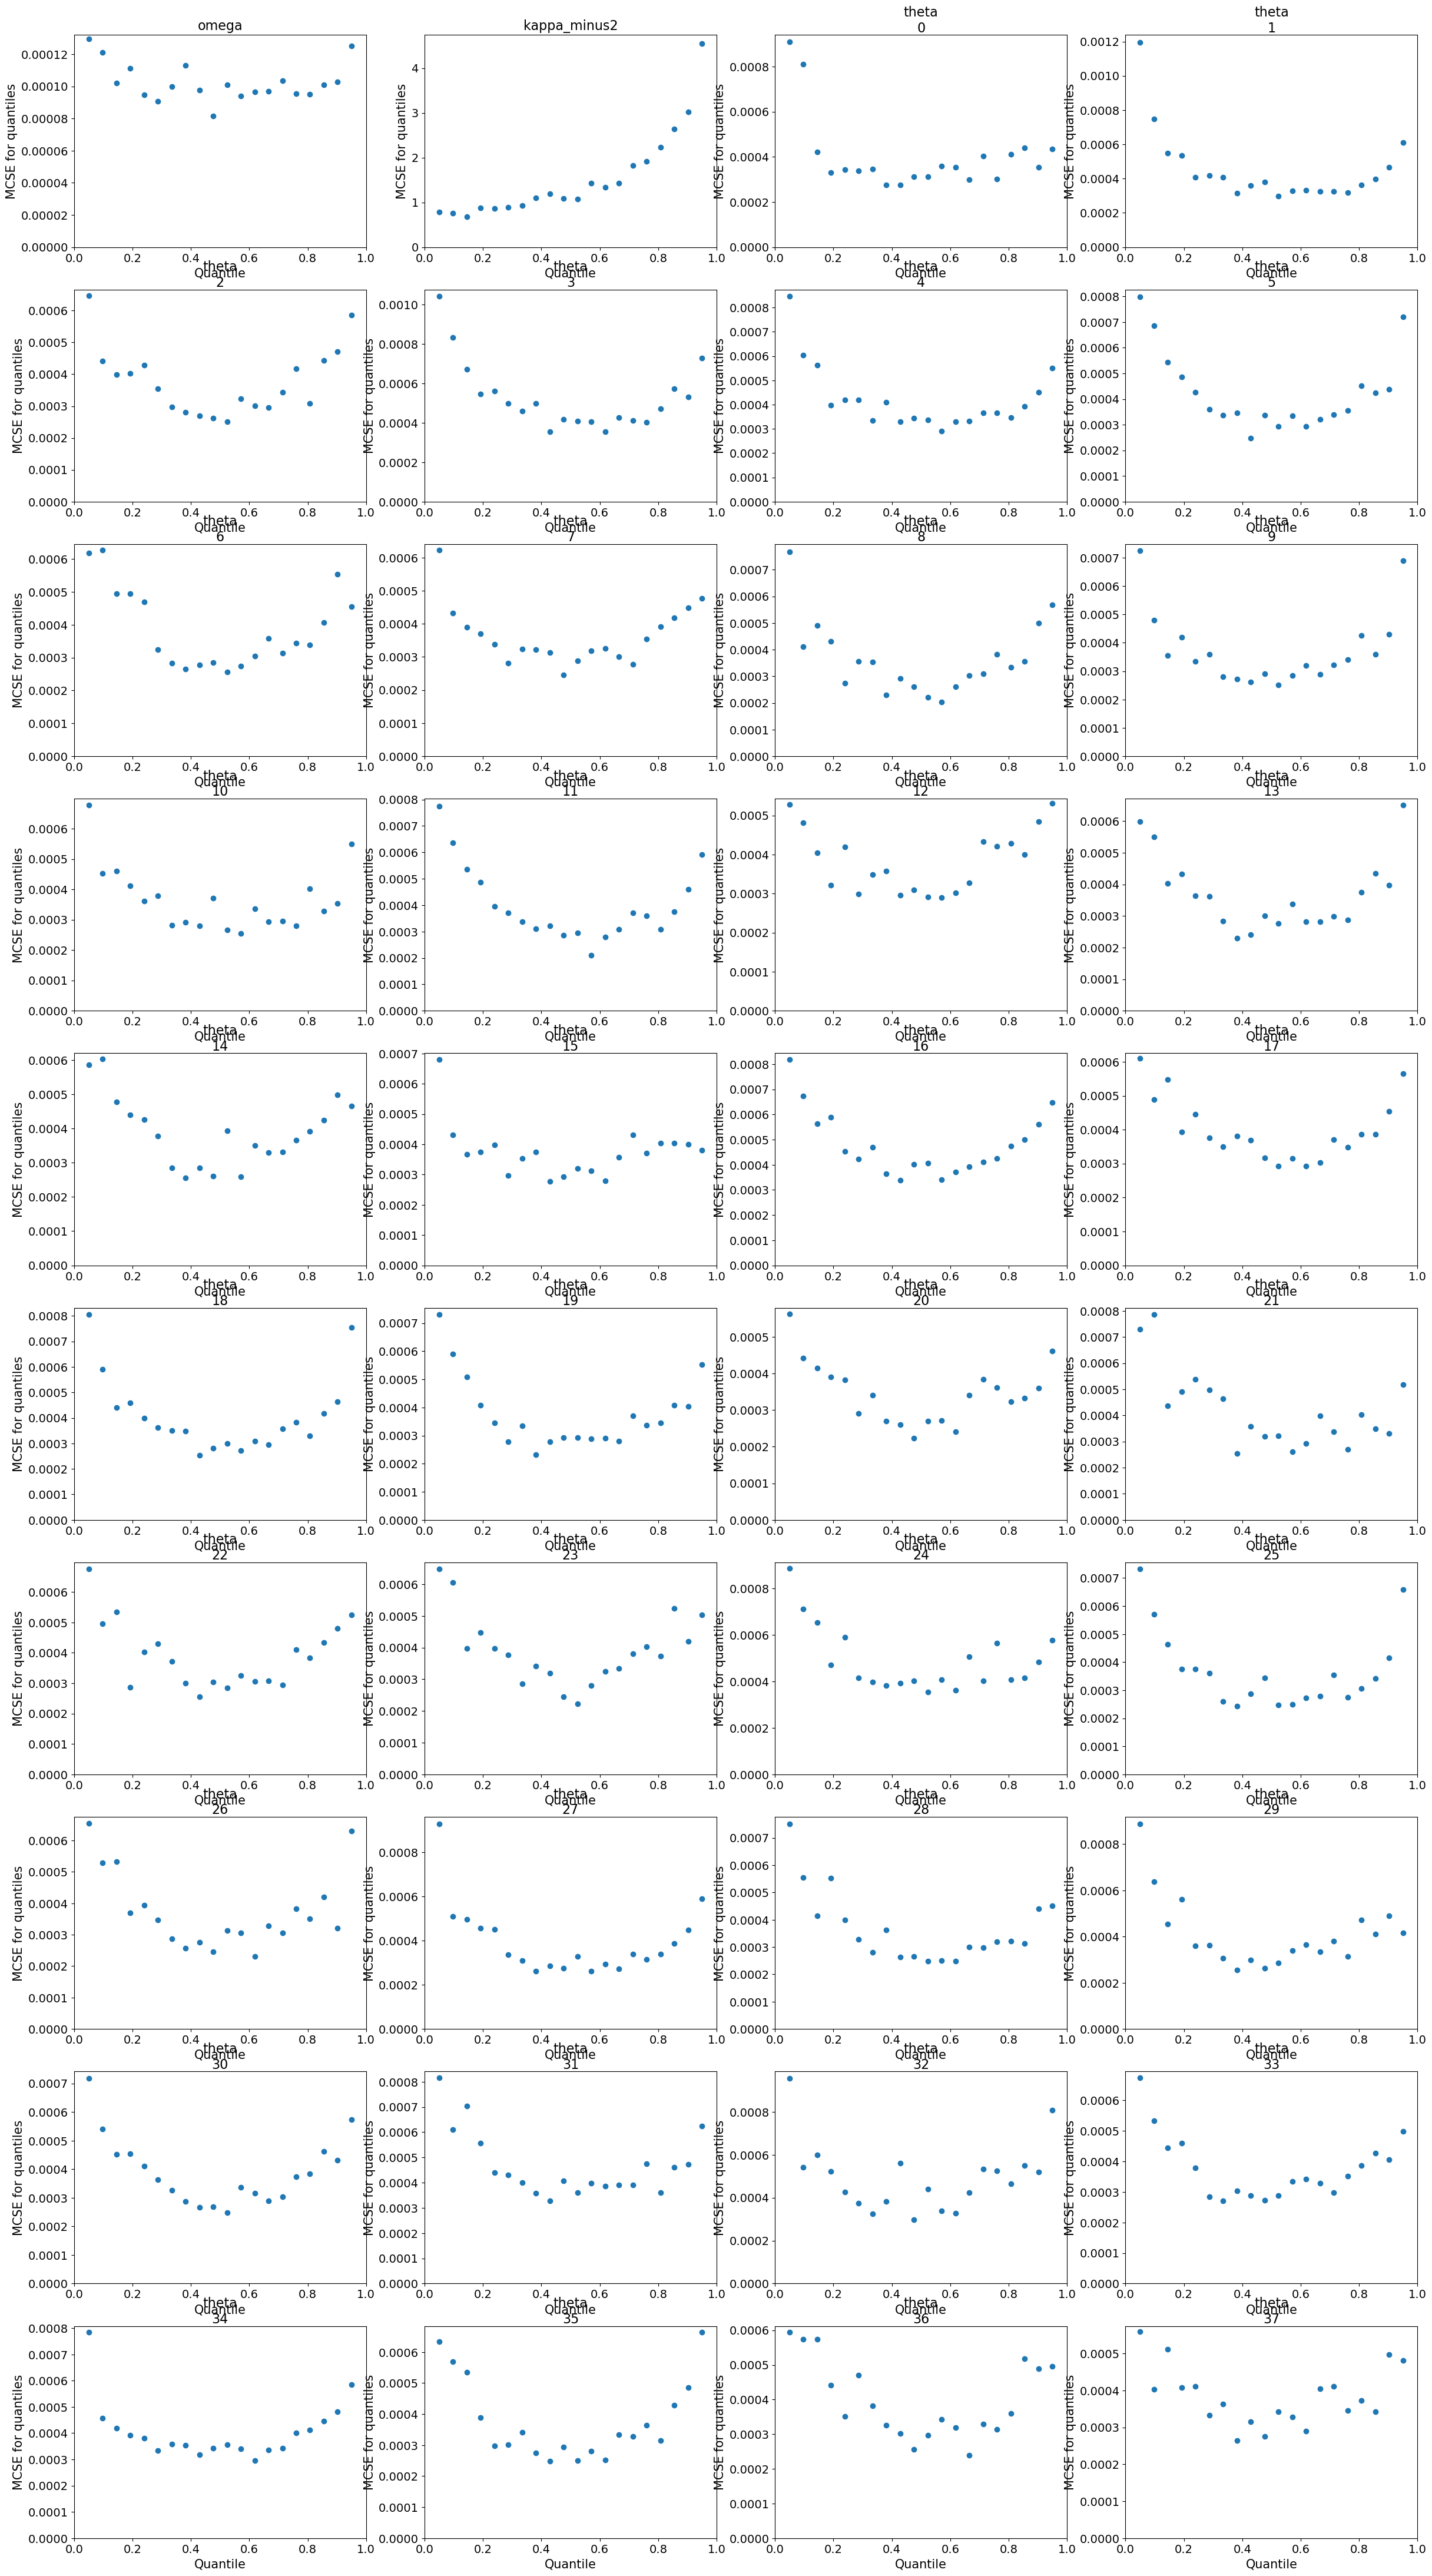

In [21]:
az.plot_mcse(idata)

/home/data-scientist/anaconda3/lib/python3.9/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (129) in plot_ess, generating only 40 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'omega'}, xlabel='Quantile', ylabel='ESS for small intervals'>,
        <AxesSubplot:title={'center':'kappa_minus2'}, xlabel='Quantile', ylabel='ESS for small intervals'>,
        <AxesSubplot:title={'center':'theta\n0'}, xlabel='Quantile', ylabel='ESS for small intervals'>,
        <AxesSubplot:title={'center':'theta\n1'}, xlabel='Quantile', ylabel='ESS for small intervals'>],
       [<AxesSubplot:title={'center':'theta\n2'}, xlabel='Quantile', ylabel='ESS for small intervals'>,
        <AxesSubplot:title={'center':'theta\n3'}, xlabel='Quantile', ylabel='ESS for small intervals'>,
        <AxesSubplot:title={'center':'theta\n4'}, xlabel='Quantile', ylabel='ESS for small intervals'>,
        <AxesSubplot:title={'center':'theta\n5'}, xlabel='Quantile', ylabel='ESS for small intervals'>],
       [<AxesSubplot:title={'center':'theta\n6'}, xlabel='Quantile', ylabel='ESS for small intervals'>,
        <AxesSubplot:title={'center':'theta\n7'}, xlabel='Qua

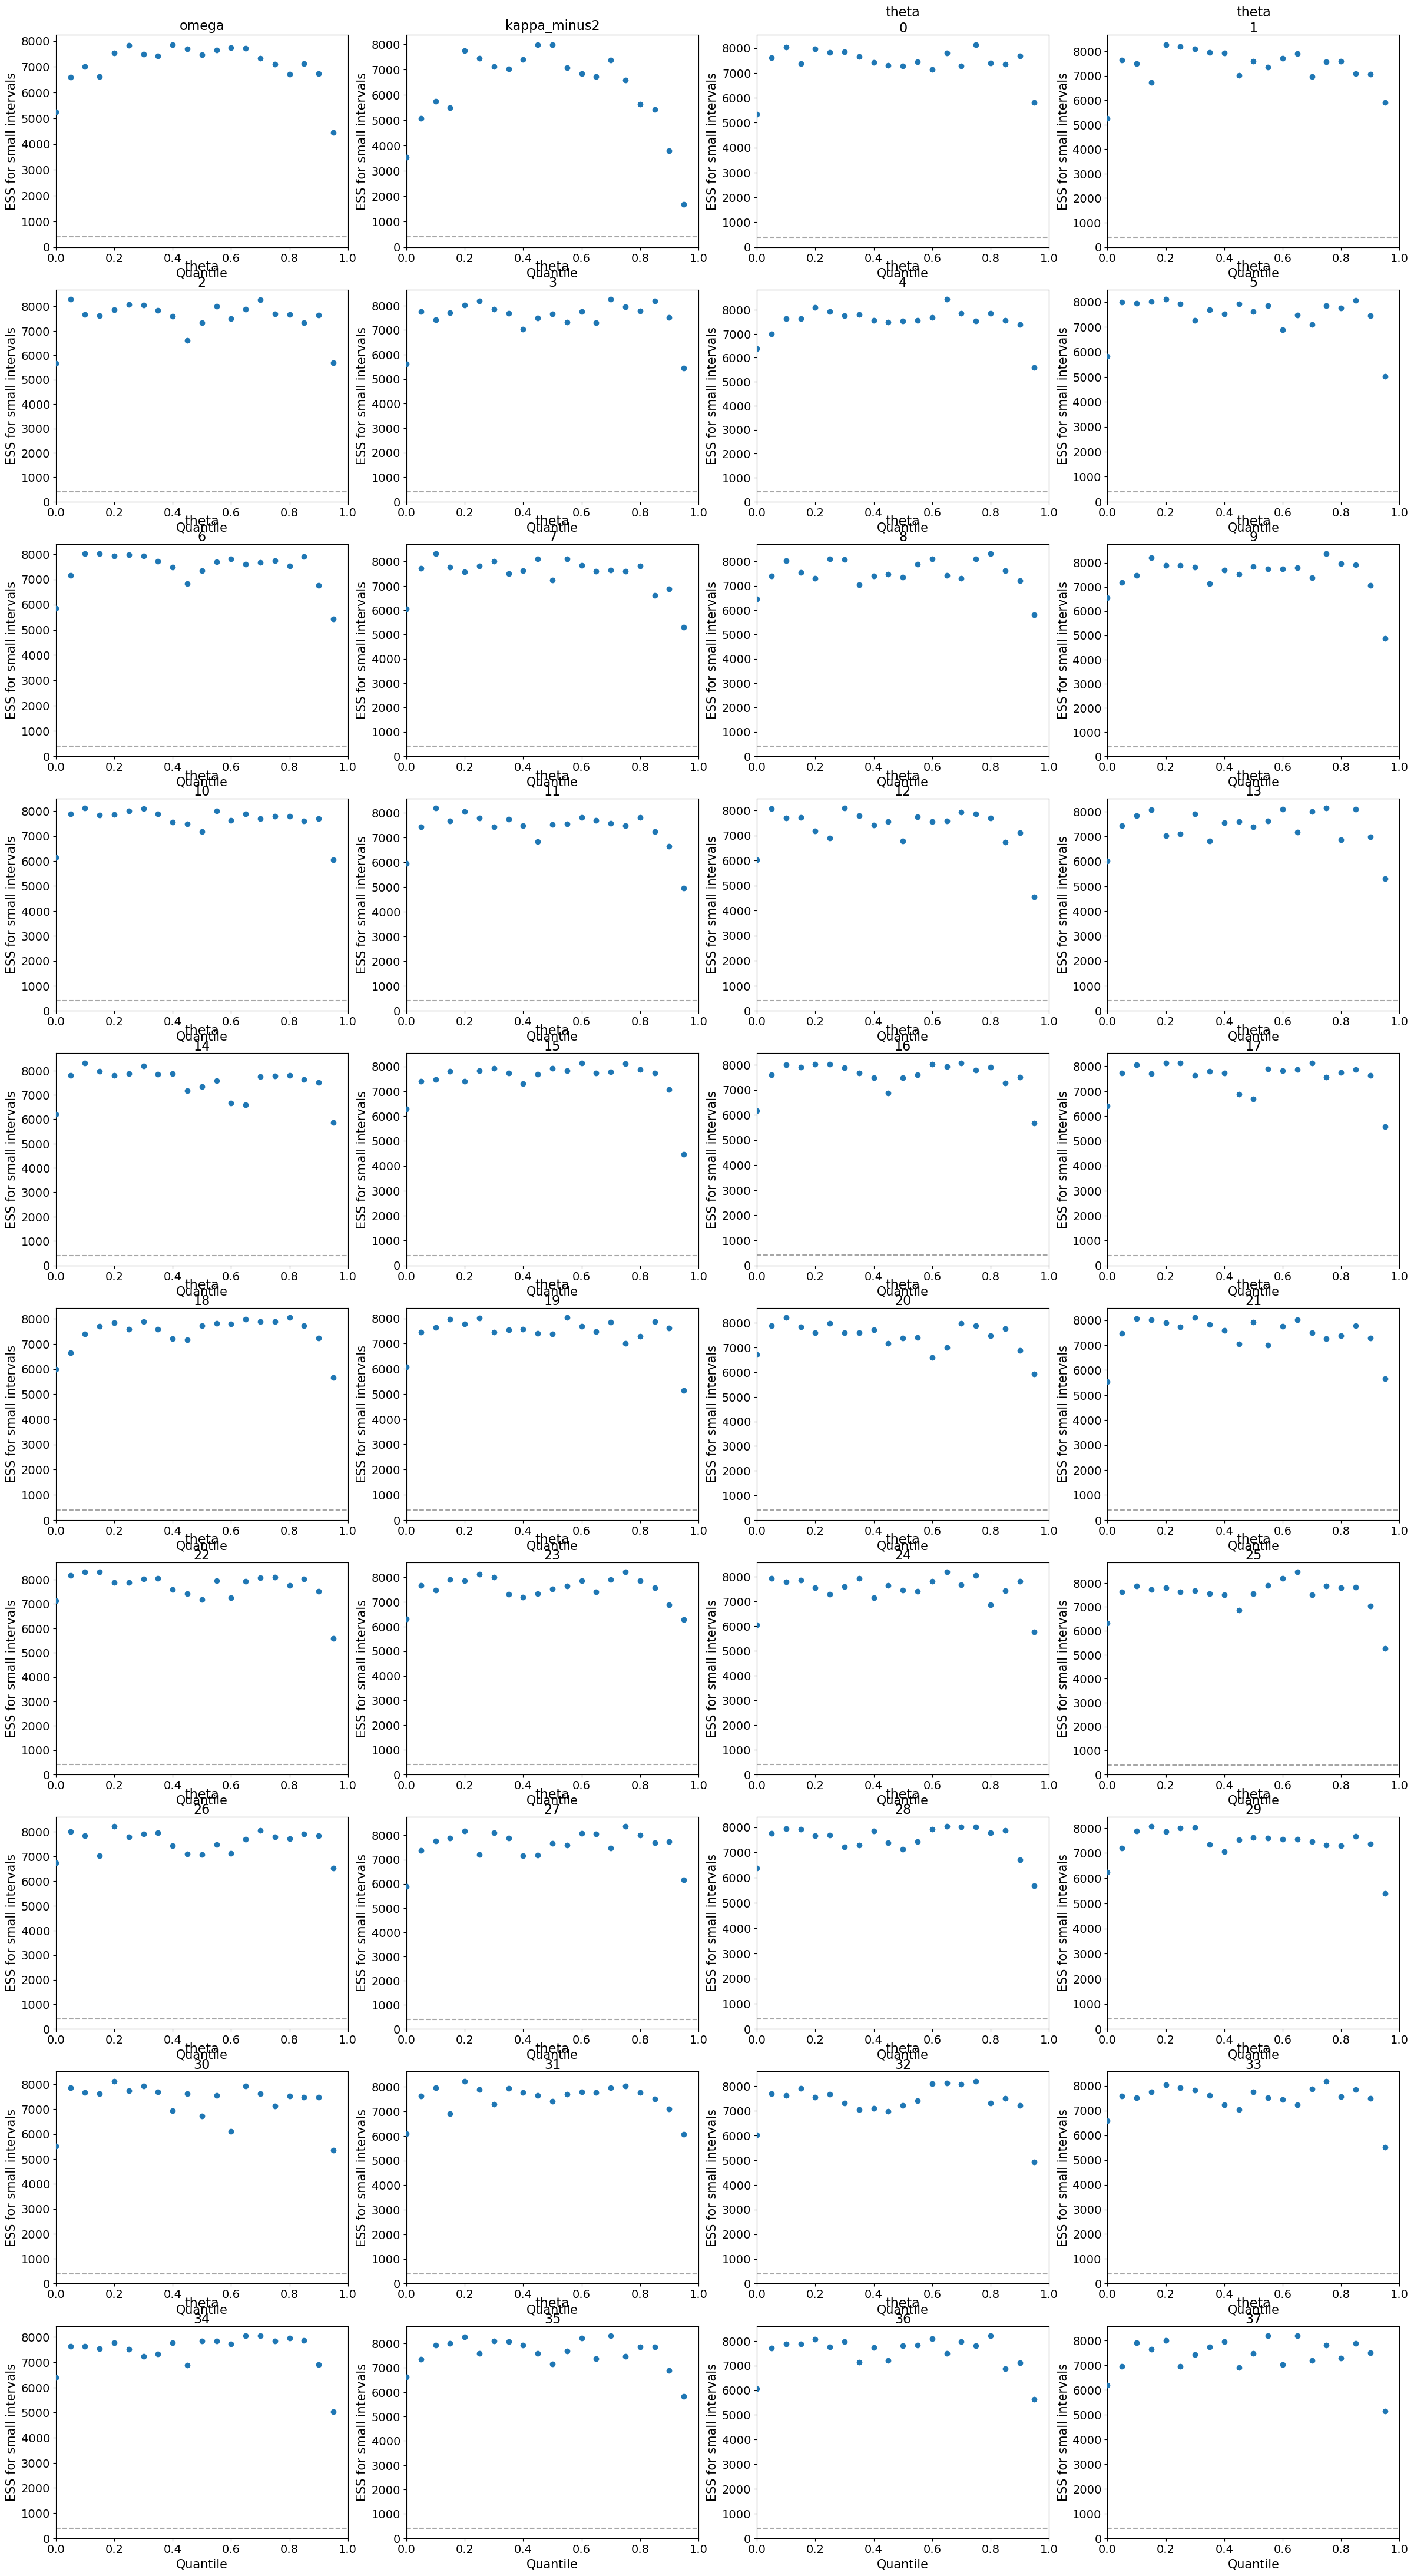

In [22]:
az.plot_ess(idata)

/home/data-scientist/anaconda3/lib/python3.9/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (129) in plot_rank, generating only 40 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'omega'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'kappa_minus2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'theta\n0'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'theta\n1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<AxesSubplot:title={'center':'theta\n2'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'theta\n3'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'theta\n4'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'theta\n5'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<AxesSubplot:title={'center':'theta\n6'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'theta\n7'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <AxesSubplot:title={'center':'theta\n8'

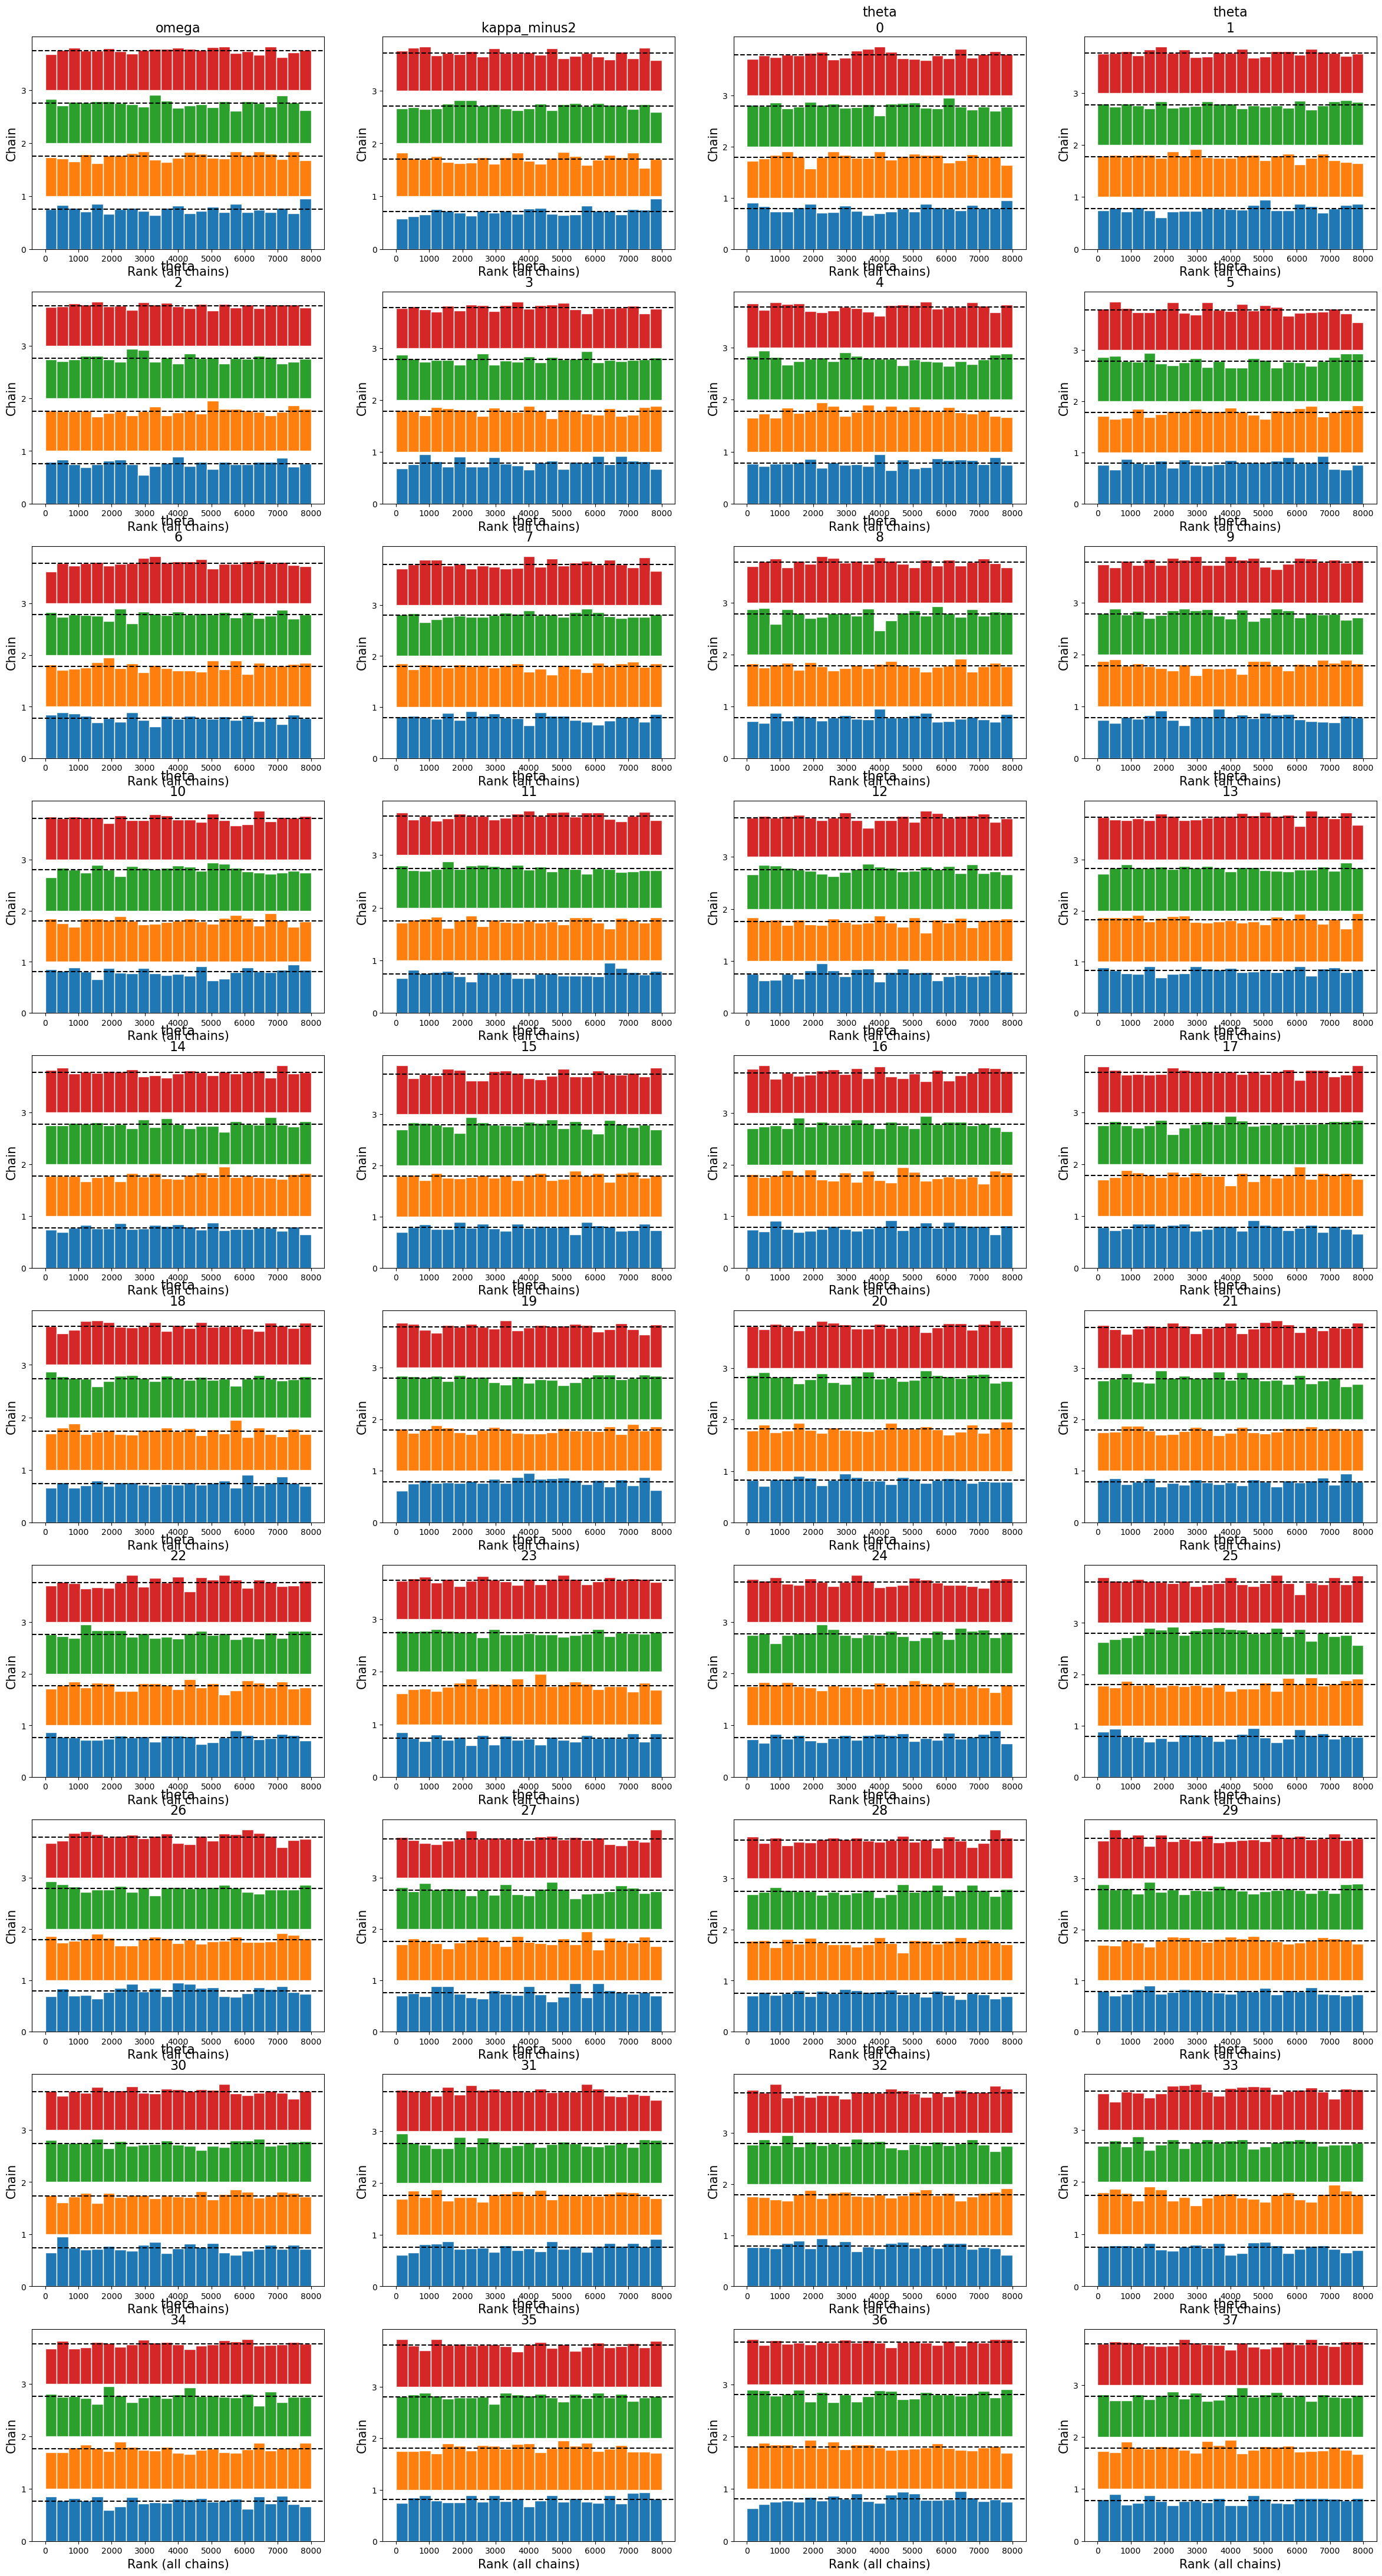

In [23]:
az.plot_rank(idata)
        

# Posterior predictive checks

/home/data-scientist/anaconda3/lib/python3.9/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (128) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'omega'}>,
        <AxesSubplot:title={'center':'kappa_minus2'}>,
        <AxesSubplot:title={'center':'theta\n0'}>,
        <AxesSubplot:title={'center':'theta\n1'}>],
       [<AxesSubplot:title={'center':'theta\n2'}>,
        <AxesSubplot:title={'center':'theta\n3'}>,
        <AxesSubplot:title={'center':'theta\n4'}>,
        <AxesSubplot:title={'center':'theta\n5'}>],
       [<AxesSubplot:title={'center':'theta\n6'}>,
        <AxesSubplot:title={'center':'theta\n7'}>,
        <AxesSubplot:title={'center':'theta\n8'}>,
        <AxesSubplot:title={'center':'theta\n9'}>],
       [<AxesSubplot:title={'center':'theta\n10'}>,
        <AxesSubplot:title={'center':'theta\n11'}>,
        <AxesSubplot:title={'center':'theta\n12'}>,
        <AxesSubplot:title={'center':'theta\n13'}>],
       [<AxesSubplot:title={'center':'theta\n14'}>,
        <AxesSubplot:title={'center':'theta\n15'}>,
        <AxesSubplot:title={'center':'theta\n16'}>,
        <AxesSubplo

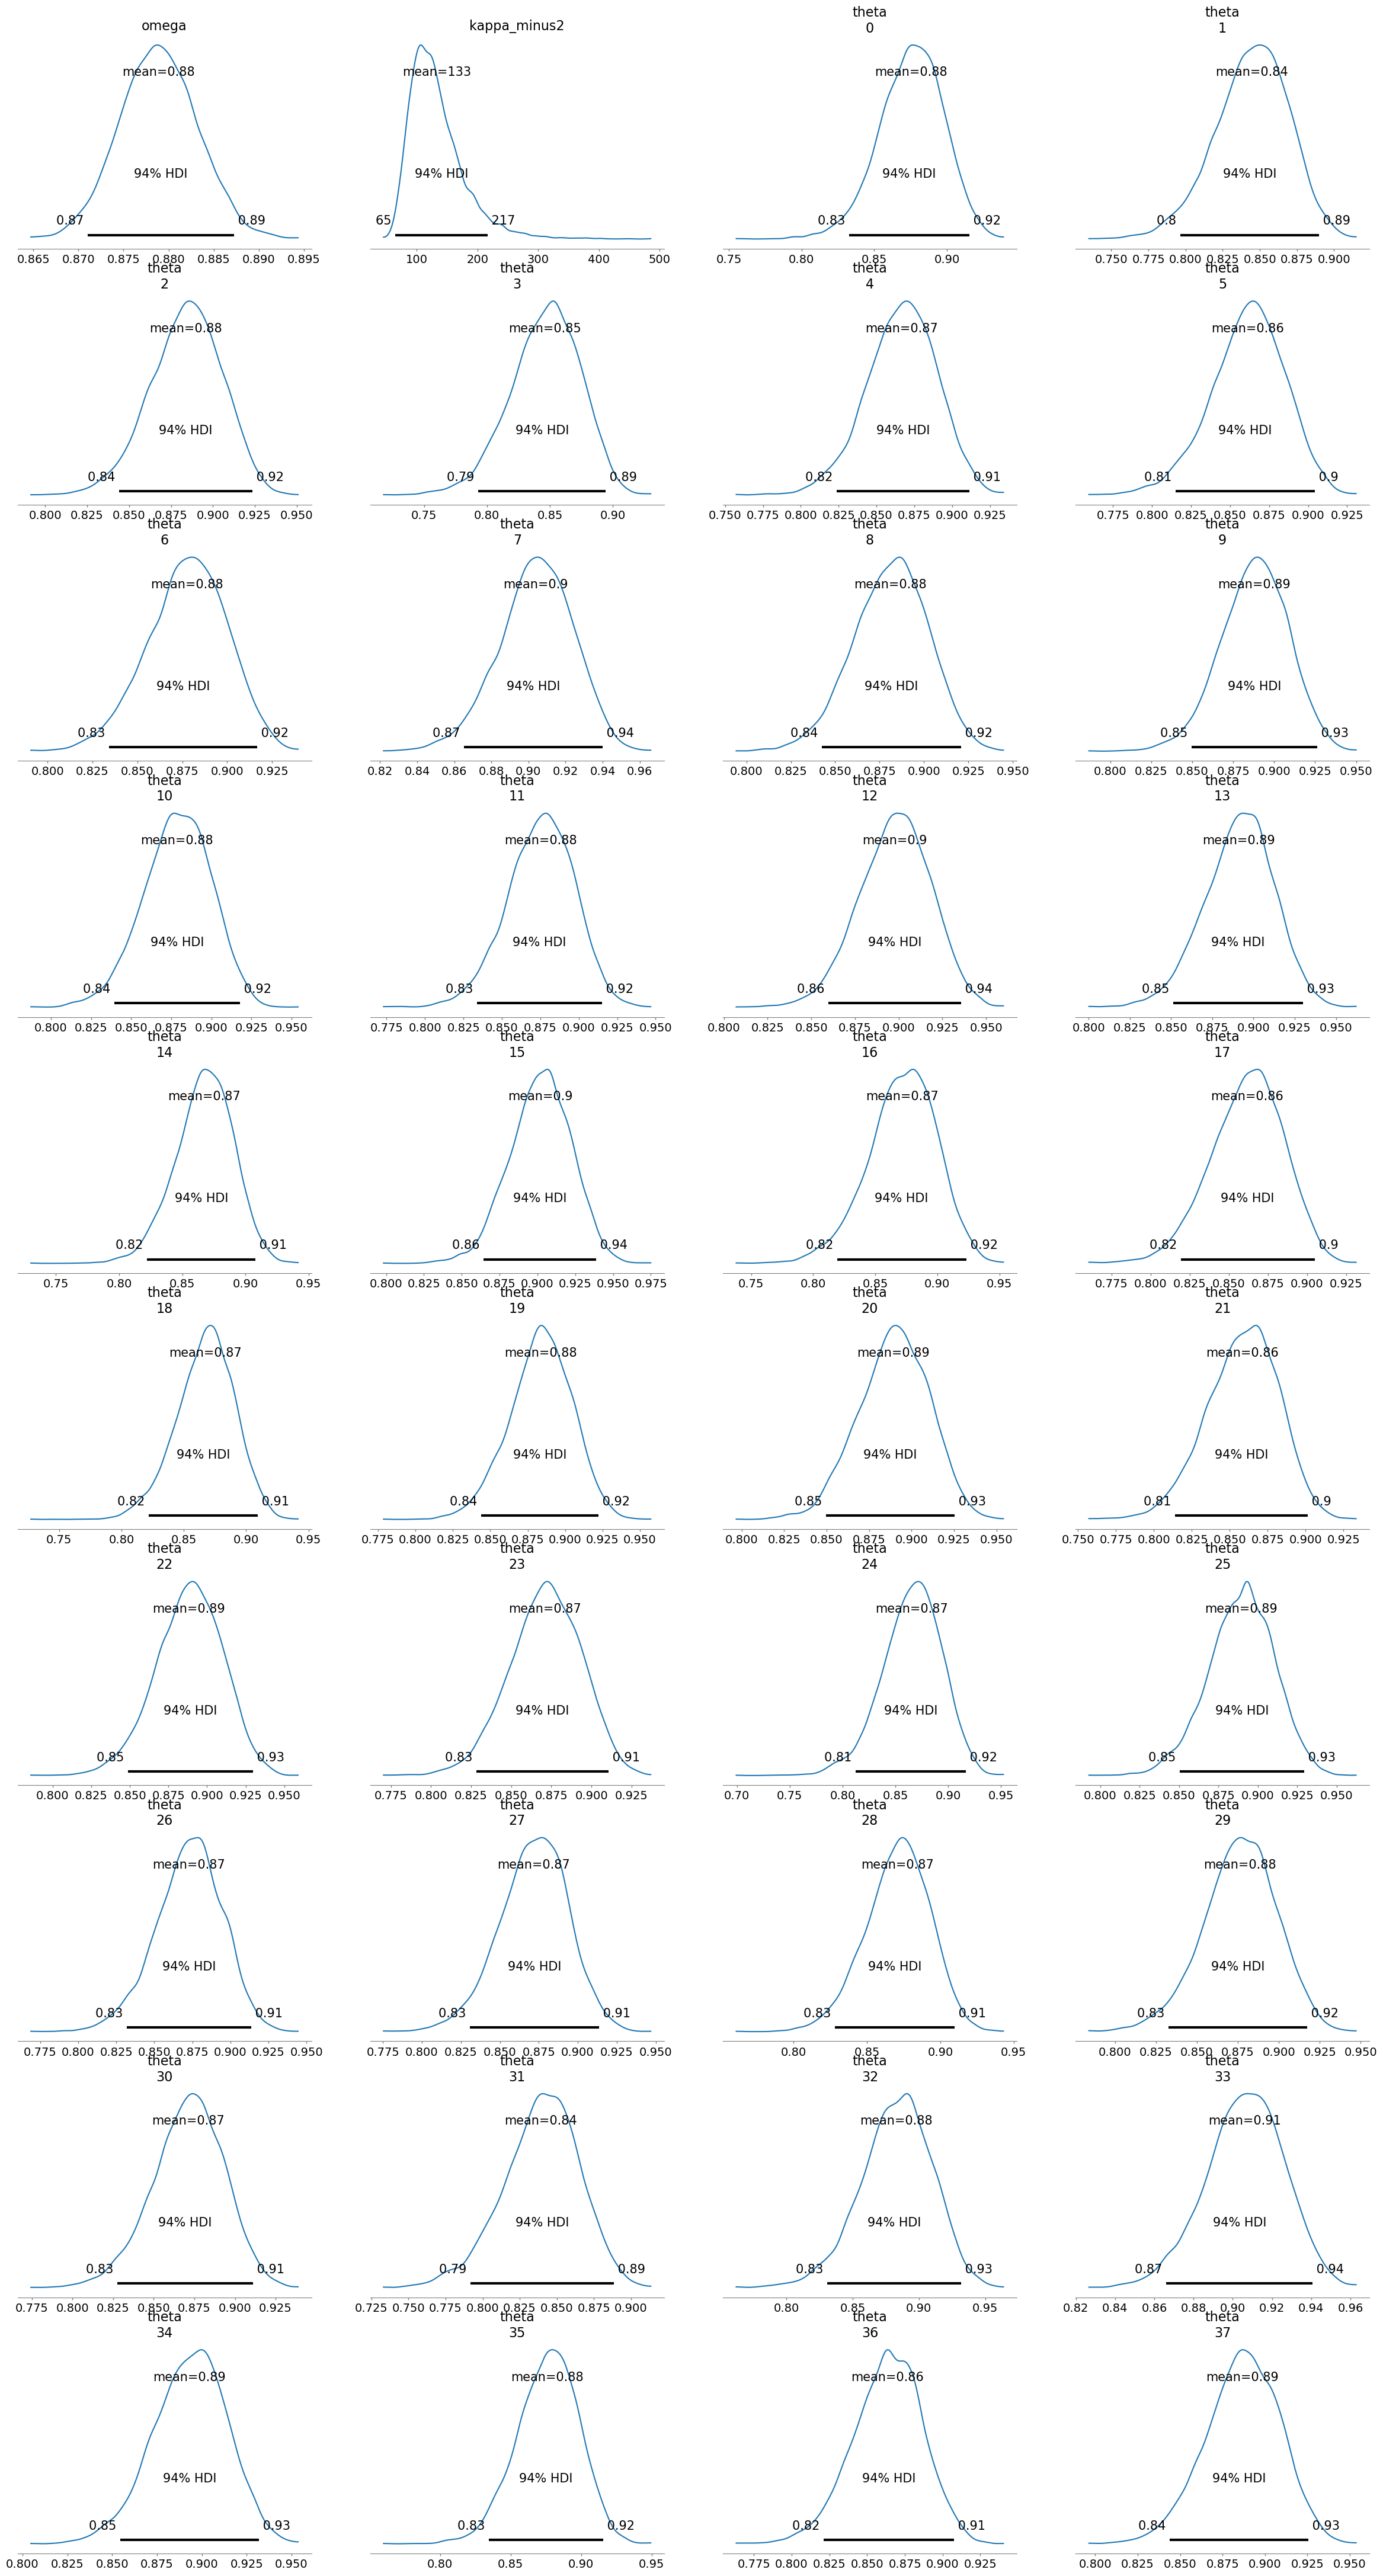

In [24]:
var_names = ['omega', 'kappa_minus2', 'theta']
#var_names = ['theta']

az.plot_posterior(idata, var_names=var_names) 


#for variable in var_names:
    #az.plot_posterior(ppc.posterior_predictive[variable]) 
    #plt.show()

# Posterior predictive checks

## Out of sample predictive checks

<AxesSubplot:xlabel='y'>

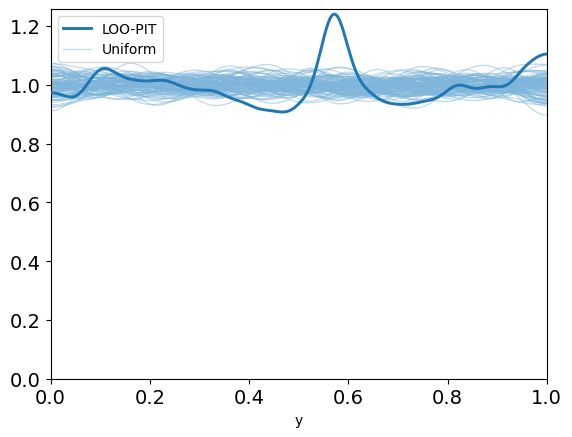

In [25]:
az.plot_loo_pit(idata=idata, y='y')

## Bayesian Pvalues 

P_Bayes = p(T_sim <= T_obs | Y_hat)
P_Bayes ideally should be 0.5 meaning that half the time T_sim is below T_obs and half the time it is above T_obs indicating a well calibrated model.
Central limit theorem says distirbution of sample means is normal....so given a simulation is a sample...distirbution of sample means should be normal...

<AxesSubplot:title={'center':'y / y'}>

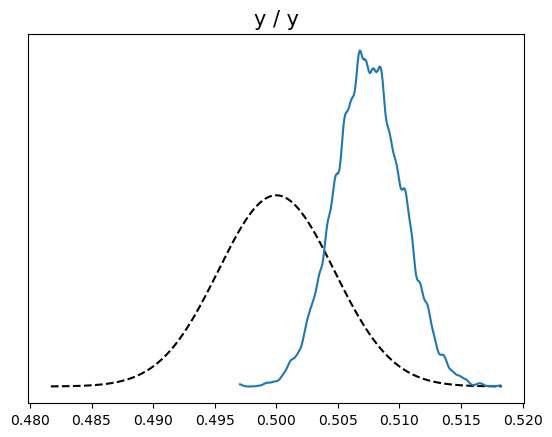

In [26]:
az.plot_bpv(data=idata, kind="p_value")

<AxesSubplot:title={'center':'y / y'}>

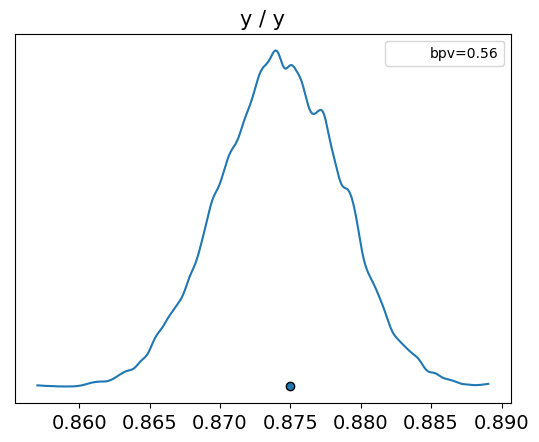

In [27]:
az.plot_bpv(data=idata, kind="t_stat", t_stat="mean", bpv=True)

<AxesSubplot:title={'center':'y / y'}>

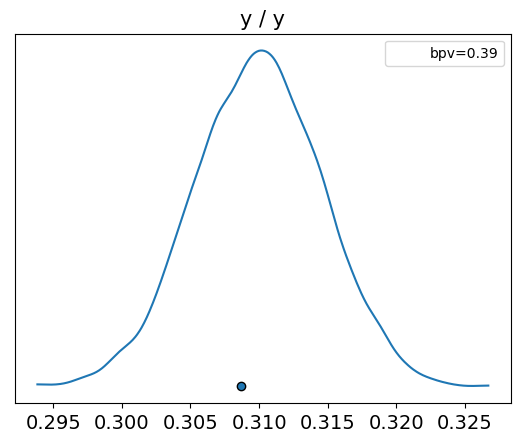

In [28]:
az.plot_bpv(data=idata, kind="t_stat", t_stat="std", bpv=True)

<AxesSubplot:title={'center':'y / y'}>

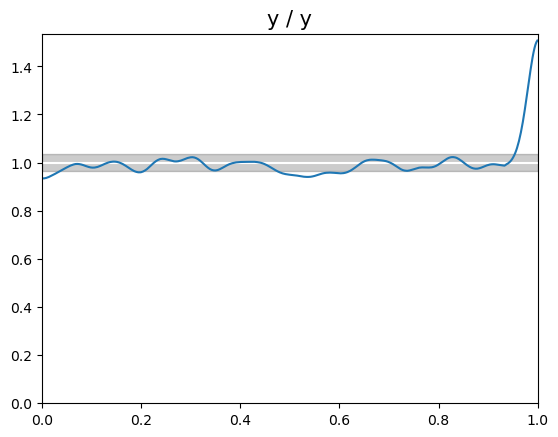

In [29]:
az.plot_bpv(idata, kind="u_value")

In [30]:
odds_dict = {"HomeTeam":['Liverpool', 'Southampton', 'Leicester', 'West Ham', 'Bournemout', 'Crystal Palace', 'Leeds', 'Man City', 'Arsenal', 'Fulham'],
             "over_4.5_back": [5.9, 8.8, 6.6, 9, 11, 9.2, 5.3, 4.1, 5.6, 5.5],
            }
             
pd.DataFrame(odds_dict)

HomeTeam  over_4.5_back
0       Liverpool            5.9
1     Southampton            8.8
2       Leicester            6.6
3        West Ham            9.0
4      Bournemout           11.0
5  Crystal Palace            9.2
6           Leeds            5.3
7        Man City            4.1
8         Arsenal            5.6
9          Fulham            5.5